In [1]:
# Husayn El Sharif
comment = """
use PyTorch (use env004)
PyTorch version of eye disease classifier using EfficientNet-B5.

use efficientnet and force 456 x 456 size

make some tweaks to more closely match tensorflow results

tweaks:
do not standardize images using assumed mean and standard deviation. Converting to 0 to 1 range is sufficient

"""

In [2]:
# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torch.amp import autocast, GradScaler # incorporate AMP for speeding up Pytorch
scaler = GradScaler('cuda', enabled=torch.cuda.is_available())

from torchvision import models, transforms

from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

In [3]:
# Other imports
import numpy as np
import pandas as pd
import os
import glob
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageOps


In [4]:
# Check for GPU
print("Torch Version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Torch Version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


device(type='cuda')

In [5]:
# Use filenames and folders to get filepath and labels for all images
all_imagefiles_list = glob.glob(
    'eye_disease_data_resized/dataset/**/*.jpg', 
    recursive=True
)  # resized to 456x456 .jpg earlier

labels_temp = [filepath.split('/')[-2] for filepath in all_imagefiles_list]

# create dataframe with image_filepath, label
full_data_df = pd.DataFrame({
    'image_filepath': all_imagefiles_list,
    'label': labels_temp,
})
full_data_df

image_filepath     label
0     eye_disease_data_resized/dataset/cataract/0_le...  cataract
1     eye_disease_data_resized/dataset/cataract/103_...  cataract
2     eye_disease_data_resized/dataset/cataract/1062...  cataract
3     eye_disease_data_resized/dataset/cataract/1083...  cataract
4     eye_disease_data_resized/dataset/cataract/1084...  cataract
...                                                 ...       ...
4011  eye_disease_data_resized/dataset/normal/8_righ...    normal
4012  eye_disease_data_resized/dataset/normal/939_le...    normal
4013  eye_disease_data_resized/dataset/normal/939_ri...    normal
4014  eye_disease_data_resized/dataset/normal/951_le...    normal
4015  eye_disease_data_resized/dataset/normal/951_ri...    normal

[4016 rows x 2 columns]

In [6]:
# how many images of each label?
print(full_data_df["label"].value_counts())
comment = """
Classes appear roughly balanced in quantity.
"""

label
diabetic_retinopathy    1098
normal                  1074
cataract                 938
glaucoma                 906
Name: count, dtype: int64


In [7]:
# randomly shuffle rows (without replacement)
full_data_df_shuffled = full_data_df.sample(
    frac=1, random_state=42, ignore_index=True, replace=False
)
full_data_df_shuffled

image_filepath                 label
0     eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
1     eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
2     eye_disease_data_resized/dataset/glaucoma/_324...              glaucoma
3     eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
4     eye_disease_data_resized/dataset/normal/3113_l...                normal
...                                                 ...                   ...
4011  eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
4012  eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
4013  eye_disease_data_resized/dataset/cataract/_57_...              cataract
4014  eye_disease_data_resized/dataset/normal/2907_r...                normal
4015  eye_disease_data_resized/dataset/normal/2572_l...                normal

[4016 rows x 2 columns]

In [8]:
# Create integer class labels
# Instead of one-hot booleans, we’ll use integer class indices (better for CrossEntropyLoss).

labels = full_data_df_shuffled['label'].values.tolist()
unique_labels = sorted(np.unique(labels))  # e.g. ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

int_labels = [label_to_idx[l] for l in labels]

In [9]:
NUM_CLASSES = len(unique_labels)

In [10]:
# Setup X and y
X = full_data_df_shuffled["image_filepath"].tolist()
y = int_labels
len(X), len(y), unique_labels, label_to_idx

(4016,
 4016,
 [np.str_('cataract'),
  np.str_('diabetic_retinopathy'),
  np.str_('glaucoma'),
  np.str_('normal')],
 {np.str_('cataract'): 0,
  np.str_('diabetic_retinopathy'): 1,
  np.str_('glaucoma'): 2,
  np.str_('normal'): 3})

In [11]:
# Train/ validation / test split

# Set number of images to use for training + validation 
NUM_IMAGES = 3200

In [12]:
# train/val split on first NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(
    X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42
)

In [13]:
# test data from leftover images
X_test = X[NUM_IMAGES:]
y_test = y[NUM_IMAGES:]

In [14]:
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)


(2560, 2560, 640, 640, 816, 816)

In [15]:
# Dataset & DataLoader with padding + resizing
# pad to square, then resize to 456×456, normalize.

IMG_SIZE_HEIGHT = 456
IMG_SIZE_WIDTH = 456
BATCH_SIZE = 32

def pad_to_square(img: Image.Image, fill=0):
    """
    Pads a PIL image to make it square, centering the original image.
    """
    w, h = img.size
    if w == h:
        return img
    side = max(w, h)
    # Create a new black (or fill) image and paste centered
    new_img = Image.new("RGB", (side, side), color=fill)
    left = (side - w) // 2
    top = (side - h) // 2
    new_img.paste(img, (left, top))
    return new_img

# Transforms (ImageNet-style normalization for EfficientNet)
train_transform = transforms.Compose([
    pad_to_square,
    transforms.Resize((IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH)),
    transforms.ToTensor(),   # converts to [0,1]
])

val_test_transform = transforms.Compose([
    pad_to_square,
    transforms.Resize((IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH)),
    transforms.ToTensor(),
])

In [16]:
class EyeDiseaseDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        return img, label


In [17]:
# Create datasets
train_dataset = EyeDiseaseDataset(X_train, y_train, transform = train_transform)
val_dataset   = EyeDiseaseDataset(X_val,   y_val,   transform = val_test_transform)
test_dataset  = EyeDiseaseDataset(X_test,  y_test,  transform = val_test_transform)

In [18]:
# Create dataloaders (handles batching, shuffling, parallel data loading, and provides memory efficiency by loading data into chunks/batches)
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [19]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2560, 640, 816)

In [20]:
# EfficientNet-B5 model in PyTorch
# We’ll use torchvision.models.efficientnet_b5 and replace the classifier head with a 4-class linear layer.

# Load pre-trained EfficientNet-B5
weights = EfficientNet_B5_Weights.IMAGENET1K_V1
model = efficientnet_b5(weights=weights)

# 1) Freeze the backbone (all layers by default), allows for massive GPU memory savings (not fine-tuning the entire EfficientNet model, and for using a larger batch size)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head (this stays trainable)
# replace the final classification layer with a new one that outputs a different number of classes (from the original EfficientNet pre-trained model)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

# move model to GPU
model = model.to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [21]:
# Loss, optimizer, simple training loop (with best-model checkpoint)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=1e-3) # telling the optimizer to only update the classifier

NUM_EPOCHS = 50
save_dir = "saved_models_pytorch"
os.makedirs(save_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
best_model_path = os.path.join(save_dir, f"best_model_{timestamp}.pth")

best_val_acc = 0.0 # initialization
patience = 6 # increased compared to tensorflow
epochs_no_improve = 0 # intialize counter

In [22]:
def accuracy_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

In [23]:
# to help with GPU memory
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [24]:
PRINT_EVERY = 20   # print every 20 batches

for epoch in range(NUM_EPOCHS):
    ################################
    # Train
    ################################
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for batch_idx, (images, labels_batch) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        labels_batch = labels_batch.to(device, non_blocking=True)

        optimizer.zero_grad()

        # --- AMP context ---
        with autocast('cuda', enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, labels_batch)

            if batch_idx % PRINT_EVERY == 0:
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
                      f"Batch [{batch_idx}/{len(train_loader)}] "
                      f"Loss: {loss.item():.4f}")

        # --- scaled backward + step ---
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * labels_batch.size(0)
        running_correct += (outputs.argmax(1) == labels_batch).sum().item()
        running_total += labels_batch.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    ################################
    # Validation
    ################################
    model.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        # you *can* also wrap this in autocast for a bit more speed
        for images, labels_batch in val_loader:
            images = images.to(device, non_blocking=True)
            labels_batch = labels_batch.to(device, non_blocking=True)

            with autocast('cuda', enabled=torch.cuda.is_available()):
                outputs = model(images)
                loss = criterion(outputs, labels_batch)

            val_loss_sum += loss.item() * labels_batch.size(0)
            val_correct += (outputs.argmax(1) == labels_batch).sum().item()
            val_total += labels_batch.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Early stopping + best model checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'label_to_idx': label_to_idx,
            'idx_to_label': idx_to_label,
            'unique_labels': unique_labels,
        }, best_model_path)
        print(f"  -> New best model saved to {best_model_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] Batch [0/80] Loss: 1.4333
Epoch [1/50] Batch [20/80] Loss: 0.9672
Epoch [1/50] Batch [40/80] Loss: 0.7058
Epoch [1/50] Batch [60/80] Loss: 0.7322
Epoch [1/50] Train Loss: 0.8513 Acc: 0.7004 | Val Loss: 1.4961 Acc: 0.3047
  -> New best model saved to saved_models_pytorch/best_model_20251114-084028.pth
Epoch [2/50] Batch [0/80] Loss: 0.5425
Epoch [2/50] Batch [20/80] Loss: 0.5812
Epoch [2/50] Batch [40/80] Loss: 0.5971
Epoch [2/50] Batch [60/80] Loss: 0.4623
Epoch [2/50] Train Loss: 0.5828 Acc: 0.8027 | Val Loss: 1.1344 Acc: 0.4719
  -> New best model saved to saved_models_pytorch/best_model_20251114-084028.pth
Epoch [3/50] Batch [0/80] Loss: 0.4869
Epoch [3/50] Batch [20/80] Loss: 0.5126
Epoch [3/50] Batch [40/80] Loss: 0.4404
Epoch [3/50] Batch [60/80] Loss: 0.5591
Epoch [3/50] Train Loss: 0.5048 Acc: 0.8230 | Val Loss: 0.7482 Acc: 0.7016
  -> New best model saved to saved_models_pytorch/best_model_20251114-084028.pth
Epoch [4/50] Batch [0/80] Loss: 0.3966
Epoch [4/50] Bat

In [25]:
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

idx_to_label = checkpoint['idx_to_label']
unique_labels = checkpoint['unique_labels']
unique_labels

/tmp/ipykernel_3369/2605096054.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


[np.str_('cataract'),
 np.str_('diabetic_retinopathy'),
 np.str_('glaucoma'),
 np.str_('normal')]

In [26]:
def evaluate_loader(model, data_loader, idx_to_label_dict):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device, non_blocking=True)
            labels_batch = labels_batch.to(device, non_blocking=True)

            with autocast('cuda', enabled=torch.cuda.is_available()):
                outputs = model(images)

            all_logits.append(outputs.cpu().numpy())
            all_labels.append(labels_batch.cpu().numpy())

    all_logits = np.concatenate(all_logits, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    preds = np.argmax(all_logits, axis=1)

    # Overall metrics
    report = classification_report(
        all_labels, preds, 
        target_names=[idx_to_label_dict[i] for i in range(len(idx_to_label_dict))],
        digits=4
    )
    cm = confusion_matrix(
        [idx_to_label_dict[i] for i in all_labels],
        [idx_to_label_dict[i] for i in preds],
        labels=[idx_to_label_dict[i] for i in range(len(idx_to_label_dict))]
    )

    acc = (preds == all_labels).mean()

    return {
        "logits": all_logits,
        "labels": all_labels,
        "preds": preds,
        "report": report,
        "cm": cm,
        "accuracy": acc,
    }


In [27]:
# Train / Val / Test metrics

train_eval = evaluate_loader(model, train_loader, idx_to_label)
print("Train Accuracy:", train_eval["accuracy"])
print(train_eval["report"])


Train Accuracy: 0.93359375
                      precision    recall  f1-score   support

            cataract     0.9261    0.9624    0.9439       612
diabetic_retinopathy     0.9901    0.9859    0.9880       711
            glaucoma     0.9337    0.8330    0.8805       575
              normal     0.8834    0.9381    0.9099       662

            accuracy                         0.9336      2560
           macro avg     0.9333    0.9299    0.9306      2560
        weighted avg     0.9345    0.9336    0.9331      2560



In [28]:
val_eval = evaluate_loader(model, val_loader, idx_to_label)
print("Validation Accuracy:", val_eval["accuracy"])
print(val_eval["report"])


Validation Accuracy: 0.875
                      precision    recall  f1-score   support

            cataract     0.8735    0.9355    0.9034       155
diabetic_retinopathy     0.9695    0.9695    0.9695       164
            glaucoma     0.8651    0.7078    0.7786       154
              normal     0.7989    0.8802    0.8376       167

            accuracy                         0.8750       640
           macro avg     0.8767    0.8733    0.8723       640
        weighted avg     0.8766    0.8750    0.8731       640



In [29]:
test_eval = evaluate_loader(model, test_loader, idx_to_label)
print("Test Accuracy:", test_eval["accuracy"])
print(test_eval["report"])


Test Accuracy: 0.866421568627451
                      precision    recall  f1-score   support

            cataract     0.8449    0.9240    0.8827       171
diabetic_retinopathy     0.9595    0.9552    0.9573       223
            glaucoma     0.8200    0.6949    0.7523       177
              normal     0.8288    0.8694    0.8486       245

            accuracy                         0.8664       816
           macro avg     0.8633    0.8609    0.8602       816
        weighted avg     0.8660    0.8664    0.8646       816



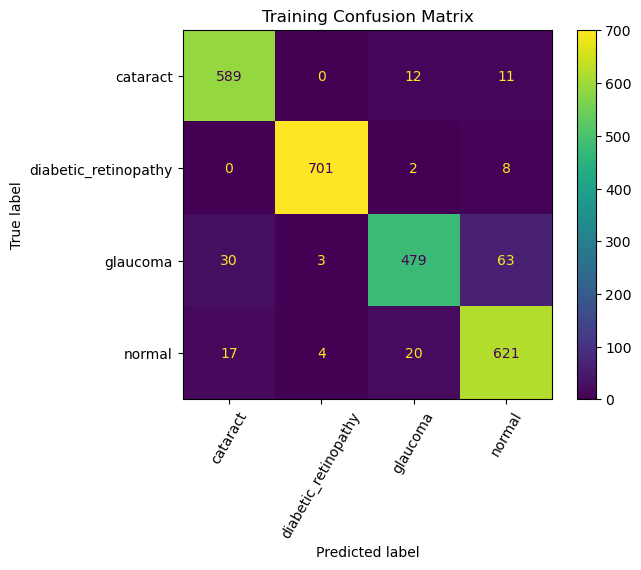

In [30]:
# Training Confusion Matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=train_eval["cm"], 
    display_labels=unique_labels
)
disp.plot(xticks_rotation=60)
plt.title("Training Confusion Matrix")
plt.show()


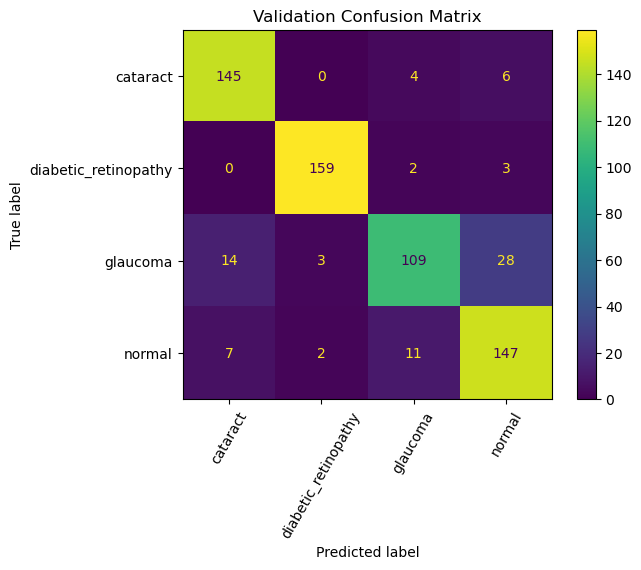

In [31]:
# Validation Confusion Matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=val_eval["cm"], 
    display_labels=unique_labels
)
disp.plot(xticks_rotation=60)
plt.title("Validation Confusion Matrix")
plt.show()


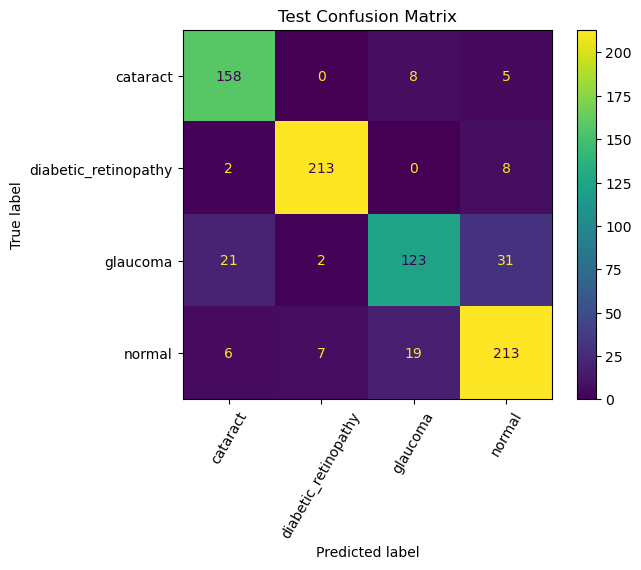

In [32]:
# Test Confusion Matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=test_eval["cm"], 
    display_labels=unique_labels
)
disp.plot(xticks_rotation=60)
plt.title("Test Confusion Matrix")
plt.show()


In [33]:
# Result DataFrames

def collect_results_df(model, data_loader, idx_to_label_dict):
    model.eval()
    all_images = []
    all_true_labels_idx = []
    all_pred_labels_idx = []

    with torch.no_grad():
        for images, labels_batch in data_loader:
            outputs = model(images.to(device))
            preds = outputs.argmax(1).cpu().numpy()

            # store images as numpy arrays in [0, 1] for visualization
            images_np = images.clone()
            images_np = images_np.clamp(0.0, 1.0)

            for img_t, true_idx, pred_idx in zip(
                images_np, labels_batch, preds
            ):
                img_hw3 = img_t.permute(1, 2, 0).cpu().numpy()  # (H,W,3)
                all_images.append(img_hw3)
                all_true_labels_idx.append(int(true_idx))
                all_pred_labels_idx.append(int(pred_idx))

    df = pd.DataFrame({
        "True_Label": [idx_to_label_dict[i] for i in all_true_labels_idx],
        "Prediction_Label": [idx_to_label_dict[i] for i in all_pred_labels_idx],
        "Image_Data": all_images,
    })
    return df


In [34]:
Train_Results_df = collect_results_df(model, train_loader, idx_to_label)
Validation_Results_df = collect_results_df(model, val_loader, idx_to_label)
Test_Results_df = collect_results_df(model, test_loader, idx_to_label)

In [35]:
Train_Results_df[['True_Label', 'Prediction_Label']]

True_Label      Prediction_Label
0                 cataract              cataract
1                 cataract              cataract
2                 glaucoma              glaucoma
3     diabetic_retinopathy  diabetic_retinopathy
4                   normal                normal
...                    ...                   ...
2555              glaucoma              glaucoma
2556              glaucoma              glaucoma
2557  diabetic_retinopathy  diabetic_retinopathy
2558                normal                normal
2559              cataract              cataract

[2560 rows x 2 columns]

In [36]:
Validation_Results_df[['True_Label', 'Prediction_Label']]

True_Label      Prediction_Label
0    diabetic_retinopathy  diabetic_retinopathy
1    diabetic_retinopathy  diabetic_retinopathy
2                cataract              cataract
3                cataract              cataract
4    diabetic_retinopathy  diabetic_retinopathy
..                    ...                   ...
635                normal                normal
636                normal              glaucoma
637              glaucoma              glaucoma
638              glaucoma              glaucoma
639                normal                normal

[640 rows x 2 columns]

In [37]:
Test_Results_df[['True_Label', 'Prediction_Label']]

True_Label      Prediction_Label
0                  normal                normal
1                glaucoma              glaucoma
2    diabetic_retinopathy  diabetic_retinopathy
3                glaucoma              glaucoma
4                  normal                normal
..                    ...                   ...
811  diabetic_retinopathy  diabetic_retinopathy
812  diabetic_retinopathy  diabetic_retinopathy
813              cataract              cataract
814                normal                normal
815                normal                normal

[816 rows x 2 columns]

In [38]:
# Figure

def to_uint8(img):
    arr = np.asarray(img)
    if arr.dtype == np.uint8:
        return arr
    if np.issubdtype(arr.dtype, np.floating) and arr.max() <= 1.0:
        arr = (np.clip(arr, 0.0, 1.0) * 255).astype(np.uint8)
    else:
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    return arr


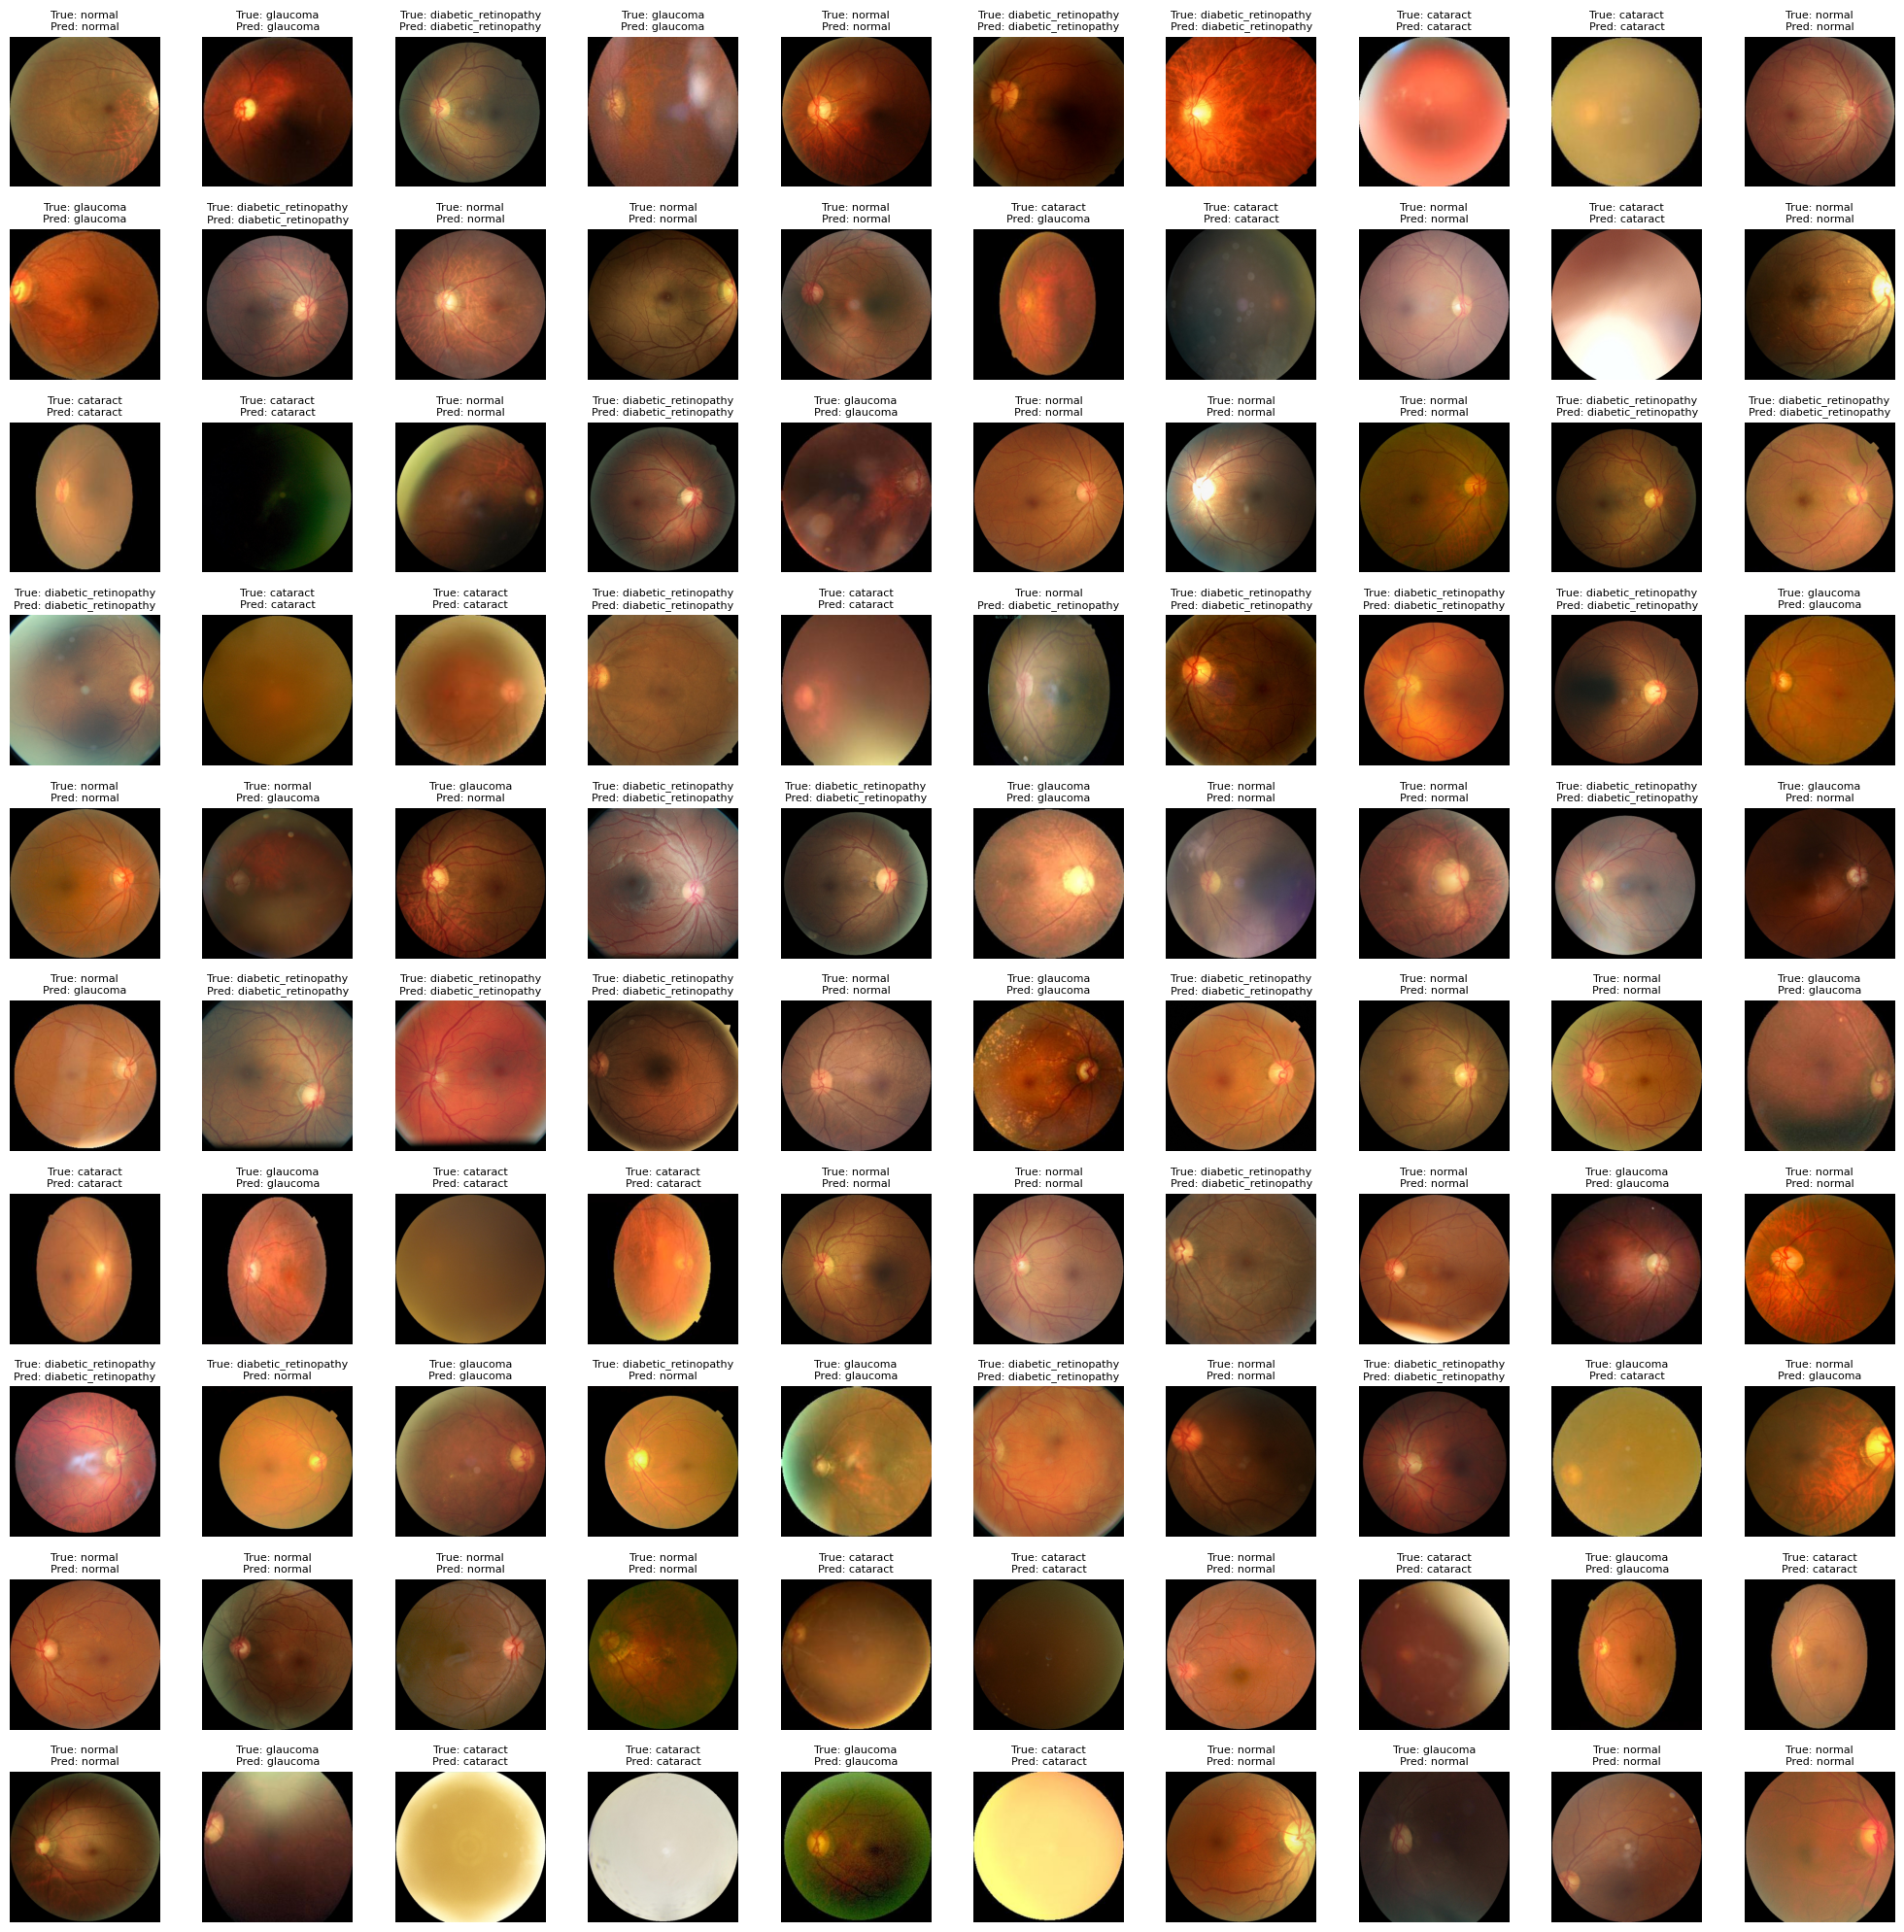

In [39]:
df = Test_Results_df.head(100)
n = len(df)
grid = int(np.ceil(np.sqrt(n)))

fig, axes = plt.subplots(grid, grid, figsize=(grid * 2, grid * 2))
axes = axes.flatten()

for idx, (_, row) in enumerate(df.iterrows()):
    ax = axes[idx]
    img = to_uint8(row["Image_Data"])
    ax.imshow(img)
    ax.set_title(
        f"True: {row['True_Label']}\nPred: {row['Prediction_Label']}",
        fontsize=8
    )
    ax.axis("off")

# Hide extra subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
